In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import json

from matplotlib.collections import LineCollection
from ast import literal_eval as make_tuple
from math import exp

np.random.seed(666)

%matplotlib inline

n_generations = 15
population_size = 25

In [2]:
def make_lattice_points(x,y):
    """Return a flat array of all lattice points that fill between the origin and (x,y)"""
    lattice_points = []
    for x in range(0, x+1):
        for y in range(0, y+1):
            point = (x,y)
            lattice_points.append(point)
    return lattice_points


def plot_lattice_points(points, **kwargs):
    """Plot a flattened array of lattice points"""
    xs = [point[0] for point in points]
    ys = [point[1] for point in points]
    plt.scatter(xs, ys, **kwargs)


def make_generations(points):
    """Transform the points into discrete-time generations"""
    generations = [ [] for i in range(points[-1][0] + 1)]
    for point in points:
        gen = point[0]
        generations[gen].append(point)
    return generations


def simulate_coalescent(generations):
    """Simulate the coalescent process on a list of generations"""
    segs = []
    # iterate backwards through the generations
    for gen in reversed(generations):
        gen_idx = gen[0][0]
        if gen_idx == 0:
            break
        # each point chooses its ancestor uniformly at random from the previous generation
        # ancestors are just keyed by their y value
        for p in gen:
            anc_idx = np.random.randint(0, len(generations[gen_idx - 1]))  # choose a random ancestor
            ancestor = (gen_idx - 1, anc_idx)
            # add the line segment from the ancestor to the current point to the list
            segs.append((ancestor, p))
    segs.reverse()
    segs.sort() # because we iterated backwards we need to reverse the list
    return segs


def untangle_coalescent(segs, generations):
    """Untangle the coalescent segments so that they can be plotted nicely"""
    point_dict = {}
    for i in range(len(segs)): # iterate through generations
        if str(segs[i][0]) not in point_dict:
            # we cheat not being able to use tuples as keys by using a string
            point_dict[str(segs[i][0])] = [segs[i][1]]
        else:
            point_dict[str(segs[i][0])].append(segs[i][1]) 
    # Sort the list of points for each connection
    for k,v in point_dict.items():
        point_dict[k] = sorted(v, key=lambda x: x[1])

    # Now we sort
    sorted_segs = []
    for i in range(len(generations)-1):
        c = 0 # set the values to this number
        for k, v in point_dict.items():
            from_pt = make_tuple(k)
            if from_pt[0] == i:
                for val in v:
                    to_pt = (i+1, c)
                    sorted_segs.append((from_pt, to_pt))
                    c += 1
    
    return sorted_segs

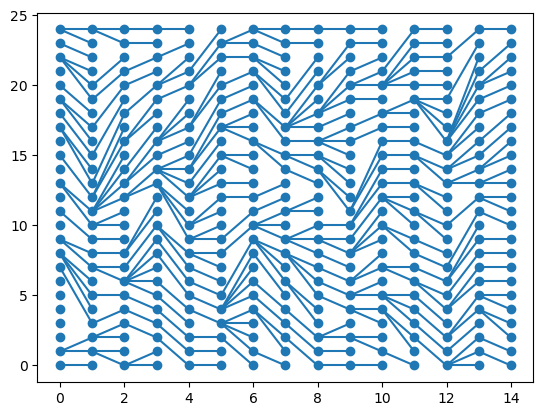

In [3]:
lpoints = make_lattice_points(n_generations-1, population_size-1) # deal with an off by one error
gen_pts = make_generations(lpoints)
coal_segs = simulate_coalescent(gen_pts)
sorted_segs = untangle_coalescent(coal_segs, gen_pts)

fig, ax = plt.subplots()
line_segments = LineCollection(sorted_segs)
plot_lattice_points(lpoints)
ax.add_collection(line_segments)
plt.show()

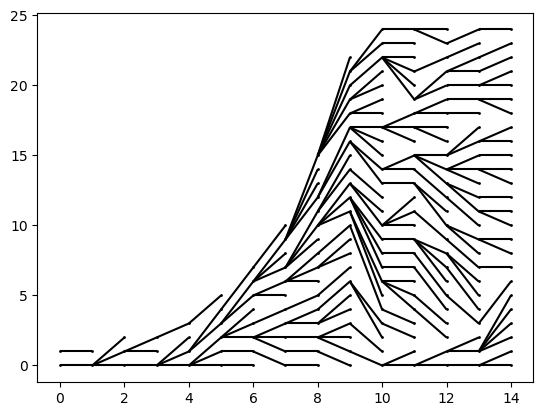

In [6]:
# Simulate under different population structures
# limiting_function = lambda x: (x**2/5)  + 1
limiting_function = lambda x: 0.5*exp(x*0.42) +1

lpoints = make_lattice_points(n_generations-1, population_size-1) # deal with an off by one error

lpoints = [item for item in lpoints if item[1] < limiting_function(item[0])]

gen_pts = make_generations(lpoints)
coal_segs = simulate_coalescent(gen_pts)
sorted_segs = untangle_coalescent(coal_segs, gen_pts)

fig, ax = plt.subplots()
line_segments = LineCollection(sorted_segs, color='k')
plot_lattice_points(lpoints, color='k', s=1)
ax.add_collection(line_segments)
plt.show()


In [7]:
class Coalescent:
    def __init__(self, n_generations, population_size, limiting_function):
        self.n_generations = n_generations
        self.population_size = population_size
        self.limiting_function = limiting_function
        self.lpoints = make_lattice_points(n_generations-1, population_size-1)
        self.lpoints = [item for item in self.lpoints if item[1] < self.limiting_function(item[0])]
        self.gen_pts = make_generations(self.lpoints)
        self.coal_segs = simulate_coalescent(self.gen_pts)
        self.sorted_segs = untangle_coalescent(self.coal_segs, self.gen_pts)
        
    def plot(self):
        fig, ax = plt.subplots()
        line_segments = LineCollection(self.sorted_segs, color='k')
        plot_lattice_points(self.lpoints, color='k', s=1)
        ax.add_collection(line_segments)
        plt.show()
        
    def to_json(self):
        return json.dumps(self.__dict__)
    
    @classmethod
    def from_json(cls, json_string):
        return cls(**json.loads(json_string))
    

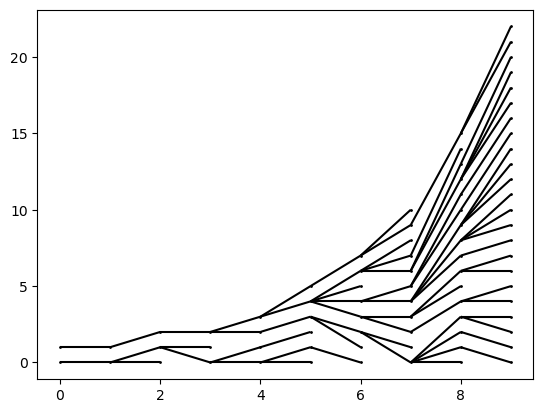

In [10]:
C = Coalescent(n_generations = 10, population_size=30, limiting_function= lambda k: 0.5*exp(k*0.42) +1)
C.plot()